In [124]:
from scipy.stats.mstats import gmean
import pandas
import numpy
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn
import matplotlib.pyplot as plt

state_list = [
  "Alabama",
  "Alaska",
  "Arizona",
  "Arkansas",
  "California",
  "Colorado",
  "Connecticut",
  "Delaware",
  "District of Columbia",
  "Florida",
  "Georgia",
  "Hawaii",
  "Idaho",
  "Illinois",
  "Indiana",
  "Iowa",
  "Kansas",
  "Kentucky",
  "Louisiana",
  "Maine",
  "Maryland",
  "Massachusetts",
  "Michigan",
  "Minnesota",
  "Mississippi",
  "Missouri",
  "Montana",
  "Nebraska",
  "Nevada",
  "New Hampshire",
  "New Jersey",
  "New Mexico",
  "New York",
  "North Carolina",
  "North Dakota",
  "Ohio",
  "Oklahoma",
  "Oregon",
  "Pennsylvania",
  "Rhode Island",
  "South Carolina",
  "South Dakota",
  "Tennessee",
  "Texas",
  "Utah",
  "Vermont",
  "Virginia",
  "Washington",
  "West Virginia",
  "Wisconsin",
  "Wyoming",
]


data_1 = pandas.read_csv("CAGDP1__ALL_AREAS_2001_2020.csv", encoding="ISO-8859-1")
data_1 = data_1[data_1["Description"] == "Real GDP (thousands of chained 2012 dollars)"]
data_1 = data_1[data_1["GeoName"].isin(state_list)]
data_1 = data_1.melt(id_vars=["GeoName"], value_vars=[str(i) for i in range(2001, 2020)], var_name="year",
                     value_name="gdp")
data_1 = data_1.dropna()
data_1 = data_1[data_1["gdp"] != "(NA)"]
data_1["gdp"] = data_1["gdp"].astype("int64")
data_1["year"] = data_1["year"].astype("int")
data_1.head()

,GeoName,year,gdp
0,Alabama,2001,156853184
1,Alaska,2001,40958700
2,Arizona,2001,213166188
3,Arkansas,2001,89789042
4,California,2001,1692324096


In [125]:
data_2 = pandas.read_excel("download.xls", skiprows=range(0, 5), nrows=59)
data_2 = data_2.melt(id_vars=["GeoName"], value_vars=[str(i) for i in range(2001, 2020)], var_name="year",
                     value_name="population")
data_2["year"] = data_2["year"].astype("int")
data_2.head()

,GeoName,year,population
0,Alabama,2001,4467634
1,Alaska *,2001,633714
2,Arizona,2001,5273477
3,Arkansas,2001,2691571
4,California,2001,34479458


In [126]:
data = pandas.merge(data_1, data_2, on=["GeoName", "year"])
data = data.rename({"GeoName": "state"}, axis=1)
data["gdp_per_capita"] = data["gdp"] / data["population"]
data_Y0 = data[data["year"] == 2001][["state", "gdp_per_capita"]]
data = data.sort_values(["state", "year"])
data["gdp_per_capita_t-1"] = data.groupby("state")["gdp_per_capita"].shift(1)
data["gdp_per_capita_growth"] = data["gdp_per_capita"] / data["gdp_per_capita_t-1"]
data = data.dropna()
data.head()

,state,year,gdp,population,gdp_per_capita,gdp_per_capita_t-1,gdp_per_capita_growth
49,Alabama,2002,160422382,4480089,35.807856,35.108781,1.019912
98,Alabama,2003,165134740,4503491,36.668163,35.807856,1.024026
147,Alabama,2004,176624994,4530729,38.983791,36.668163,1.063151
196,Alabama,2005,184369466,4569805,40.345150,38.983791,1.034921
245,Alabama,2006,187270767,4628981,40.456154,40.345150,1.002751


In [127]:
data_agg = data.groupby(by="state").agg({"gdp_per_capita_growth": [gmean]}) - 1
data_agg.columns = data_agg.columns.droplevel()
data_agg.head()

,gmean
state,
Alabama,0.009253
Arizona,0.005251
Arkansas,0.008226
California,0.019479
Colorado,0.008612


In [128]:
data_final = pandas.merge(data_agg, data_Y0, on=["state"])
data_final["ln_gdp_per_capita"] = numpy.log(data_final["gdp_per_capita"])
data_final.head()

,state,gmean,gdp_per_capita,ln_gdp_per_capita
0,Alabama,0.009253,35.108781,3.558451
1,Arizona,0.005251,40.422323,3.699382
2,Arkansas,0.008226,33.359344,3.507338
3,California,0.019479,49.082097,3.893494
4,Colorado,0.008612,53.094446,3.972072


In [129]:
X = sm.add_constant(data_final)
mod = smf.ols(formula="gmean ~ ln_gdp_per_capita", data=X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gmean   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.708
Date:                Thu, 16 Dec 2021   Prob (F-statistic):              0.198
Time:                        22:24:41   Log-Likelihood:                 181.42
No. Observations:                  49   AIC:                            -358.8
Df Residuals:                      47   BIC:                            -355.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0278      0.013      2.080      0.043       0.001       0.055
ln_gdp_per_capita    -0.0046      0.003     -1.307      0.198      -0.012       0.002
==============================================================================
Omnibus:                       23.808   Durbin-Watson:                   2.263
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.428
Skew:                           1.282   Prob(JB):                     9.20e-13
Kurtosis:                       7.536   Cond. No.                         62.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
data_final["const"] = 1
mod = sm.RLM(data_final["gmean"], data_final[["const", "ln_gdp_per_capita"]])
res = mod.fit()
res.summary()

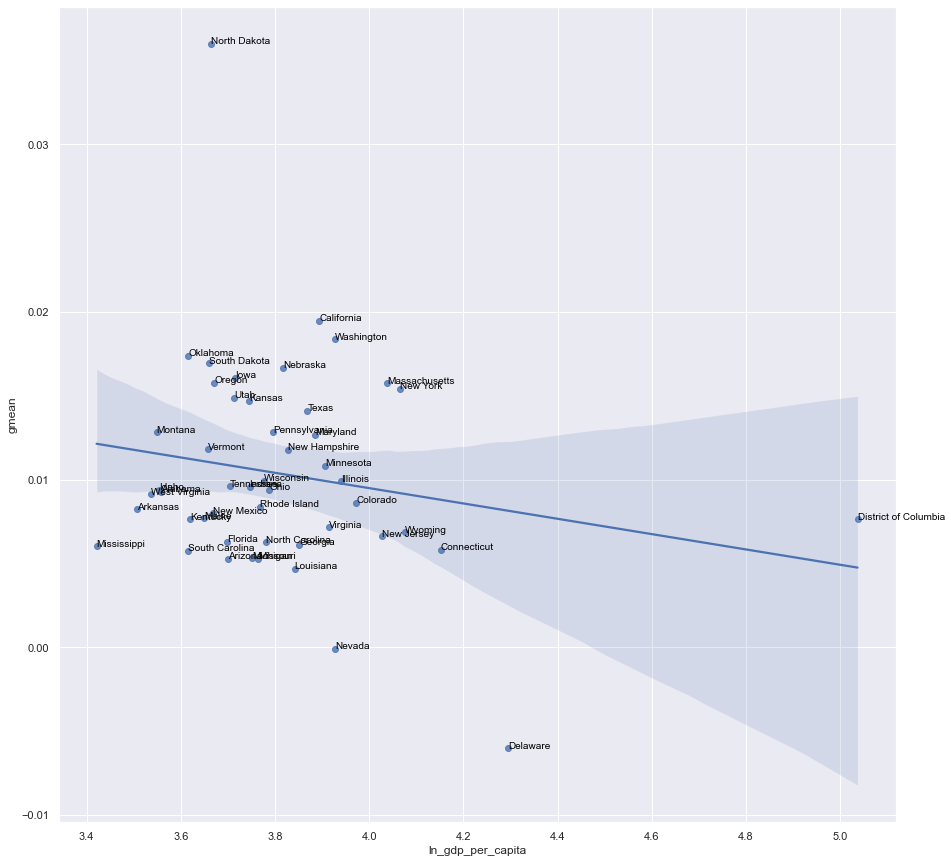

In [142]:
seaborn.set(rc={'figure.figsize':(15, 15)})
seaborn.regplot(x="ln_gdp_per_capita", y="gmean", data=data_final)
for line in range(0,data_final.shape[0]):
     plt.text(data_final.ln_gdp_per_capita[line], data_final.gmean[line], data_final.state[line], size='small', color='black')


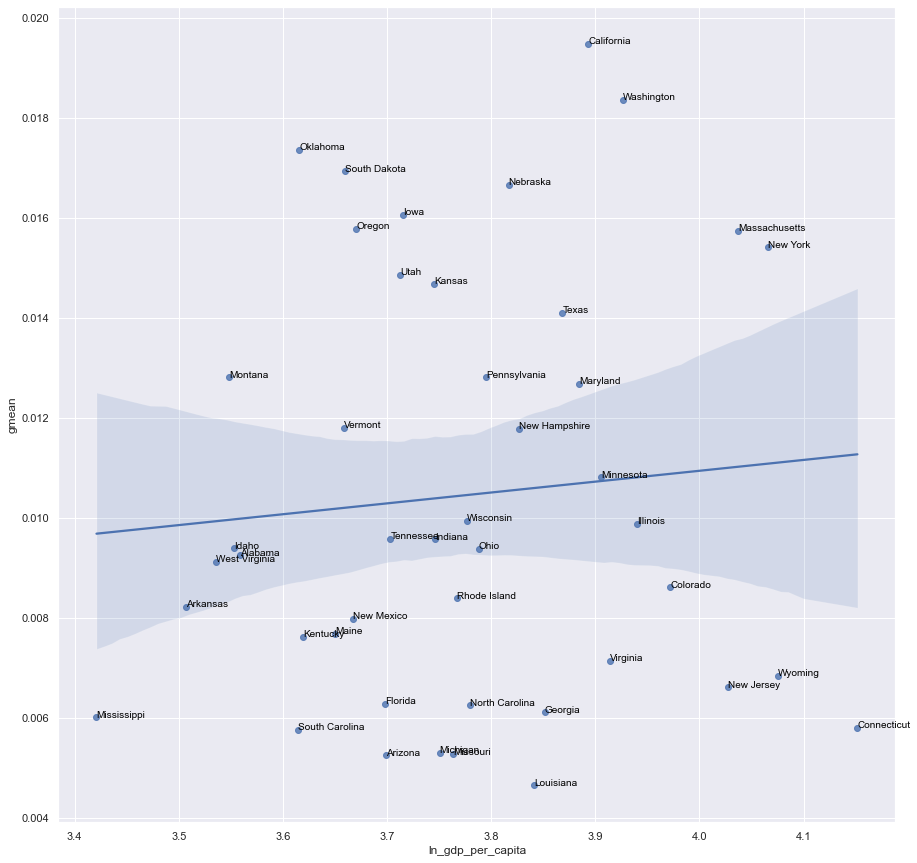

In [146]:
data_final_ro = data_final[~data_final["state"].isin(["District of Columbia", "Delaware", "Nevada", "North Dakota"])].reset_index()
seaborn.set(rc={'figure.figsize':(15, 15)})
seaborn.regplot(x="ln_gdp_per_capita", y="gmean", data=data_final_ro)
for line in range(0,data_final_ro.shape[0]):
     plt.text(data_final_ro.ln_gdp_per_capita[line], data_final_ro.gmean[line], data_final_ro.state[line], size='small', color='black')

In [147]:
X = sm.add_constant(data_final_ro)
mod = smf.ols(formula="gmean ~ ln_gdp_per_capita", data=X)
res = mod.fit()
res.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gmean   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.3180
Date:                Thu, 16 Dec 2021   Prob (F-statistic):              0.576
Time:                        22:53:25   Log-Likelihood:                 183.36
No. Observations:                  45   AIC:                            -362.7
Df Residuals:                      43   BIC:                            -359.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0023      0.015      0.155      0.878      -0.027       0.032
ln_gdp_per_capita     0.0022      0.004      0.564      0.576      -0.006       0.010
==============================================================================
Omnibus:                        5.984   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                3.336
Skew:                           0.454   Prob(JB):                        0.189
Kurtosis:                       2.022   Cond. No.                         93.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""